In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import psyneulink as pnl
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import sys; sys.path.append('./shape-naming/')
import shape_naming_model

## Plotting utility

In [3]:
DEFAULT_FIGURE_SIZE = (18, 10)
DEFAULT_TITLES = ('72 epochs', '504 epochs', '2520 epochs')
ORDERED_KEYS = ('control', 'conflict', 'congruent')

def plot_by_condition(first_results, second_results=None, third_results=None,
                     figsize=DEFAULT_FIGURE_SIZE, titles=DEFAULT_TITLES,
                     ordered_keys=ORDERED_KEYS):
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=DEFAULT_FIGURE_SIZE)
    fig.patch.set_facecolor('#DDDDDD')
    fig.suptitle('Figure 12', fontsize=24)

    plot_single_result_set(ax1, first_results, titles[0], ordered_keys)
    if second_results is not None: 
        plot_single_result_set(ax2, second_results, titles[1], ordered_keys)
    if third_results is not None:
        plot_single_result_set(ax3, third_results, titles[2], ordered_keys)
    
    plt.show()
    
def plot_single_result_set(ax, results, title, ordered_keys):
    shape_naming, color_naming, _ = results
    shape_naming_avg = [np.average(shape_naming[key]) for key in ordered_keys]
    color_naming_avg = [np.average(color_naming[key]) for key in ordered_keys]
    x_values = np.arange(3)
                                  
    ax.plot(x_values, shape_naming_avg, marker='o', markersize=10, label='shape')
    ax.plot(x_values, color_naming_avg, marker='s', markersize=10, label='color')

    ax.set_xticks(x_values)
    ax.set_xticklabels(ordered_keys)
    ax.tick_params(length=15, labelsize=16)
    ax.legend(fontsize=16)
    ax.set_title(title, dict(fontsize=16))

## First day

Create the model, train it on a day's worth of stimuli, test, plot the results

In [4]:
model = shape_naming_model.ShapeNamingModel(2)

In [5]:
# model.system.show_graph(show_dimensions=pnl.ALL, show_projection_labels=pnl.ALL, show_processes=pnl.ALL, output_fmt='jupyter')

In [6]:
first_day_train = model.train()

In [7]:
first_test_results = model.test()

In [8]:
shape_naming_results, color_naming_results, run_shape_naming_first = first_test_results

In [9]:
print('Shape-naming')
for key in shape_naming_results:
    print(key, np.average(shape_naming_results[key]))
print()
print('Color-naming')
for key in shape_naming_results:
    print(key, np.average(color_naming_results[key]))

Shape-naming
control 59.9375
congruent 66.20833333333333
conflict 67.02083333333333

Color-naming
control 38.208333333333336
congruent 40.0
conflict 36.0625


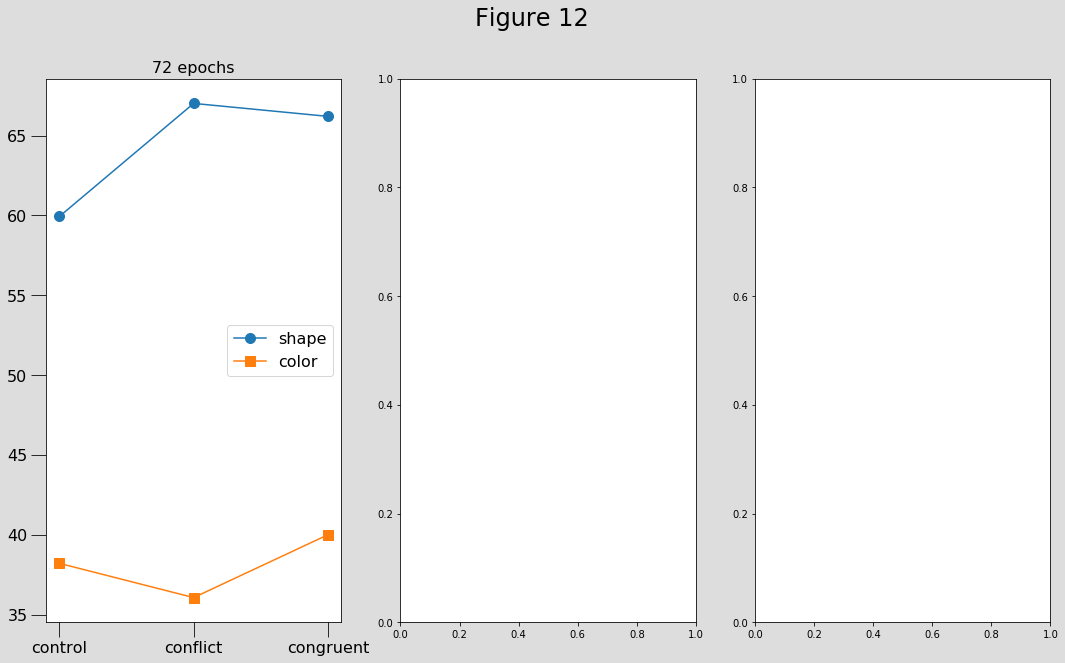

In [10]:
plot_by_condition(first_test_results)


## Train for another four days worth of training

This arrives at a total of 504 epochs, if my math is right

In [11]:
for i in range(4):
    model.train()

Test again, and then plot again

In [12]:
five_day_test_results = model.test()

In [13]:
five_day_shape_naming_results, five_day_color_naming_results, five_day_run_shape_naming_first = five_day_test_results

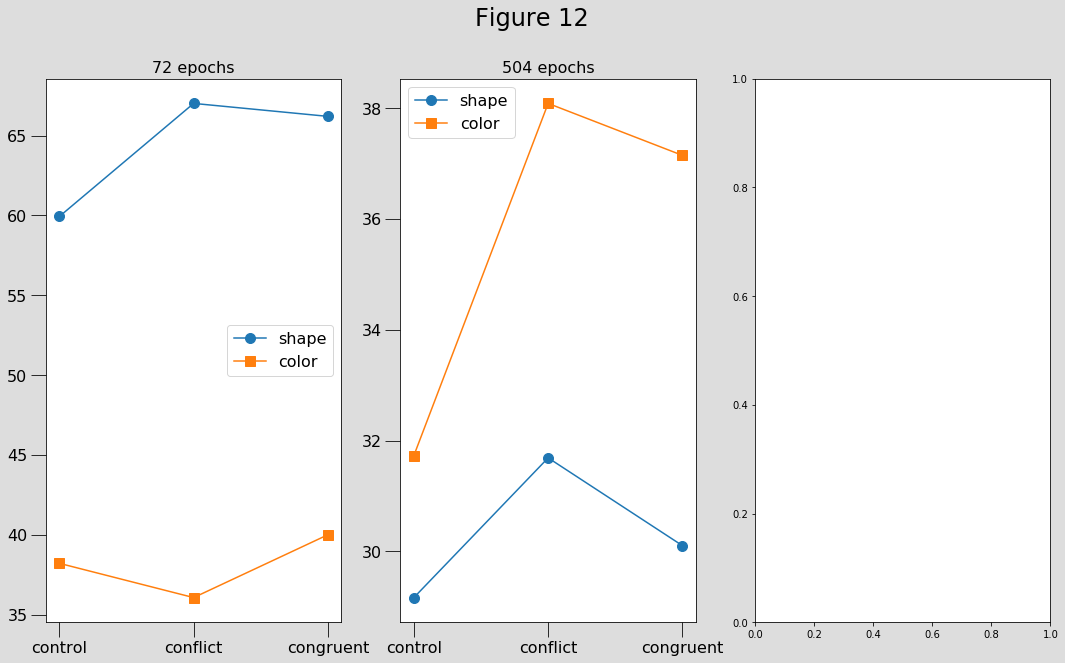

In [14]:
plot_by_condition(first_test_results, five_day_test_results)


## This is odd

After 504 training iterations, the shape-naming is already better than color naming. Additionally, the control conition appears harder than confluct, which is quite strange.

### TODO:

* Try fixing the indirect path's weights and seeing what this looks like

* ~~Verify that the stimuli I generate are all the correct ones~~

    * I definitly had a bug. Rerunning everything above to see if that fixes some of it.
    
    * It does. At least by the 5 day iteration, it looks better. However, the shape still learns much faster than the control. Additionally, why does the color-naming get better? Nothing in that pathway should learn.